In [7]:
import os, sys
parentdir = os.path.dirname(os.path.dirname(os.path.dirname(os.path.join(os.getcwd(), 'example_lin_elasticity_spikeslab.ipynb'))))
sys.path.append(parentdir)
#print(parentdir)
import numpy as np
import fenicsX_concrete
import json 

#with open('test_config.json', 'r') as f: 
#    json_object = json.loads(f.read()) 

# Adding sensors to the problem definition.
def add_sensor(length, breadth, _problem, _dirichlet_bdy, _sensors_num_edge_hor, _sensors_num_edge_ver): 
    sensor = []
    if _dirichlet_bdy == 0: #'left'
        for i in range(_sensors_num_edge_hor): 
            #print((p['length']*(i+1))/_sensors_num_edge_hor) #p['length']
            x_coord = (length*(i+1))/_sensors_num_edge_hor
            sensor.append(fenicsX_concrete.sensors.DisplacementSensor(np.array([[x_coord, 0, 0]]), 'top')) #1/20
            sensor.append(fenicsX_concrete.sensors.DisplacementSensor(np.array([[x_coord, breadth, 0]]), 'bottom'))
        
        for i in range(_sensors_num_edge_ver):
            #print((p['breadth']*(i+1))/(_sensors_num_edge_ver+1))
            y_coord = (breadth*(i+1))/(_sensors_num_edge_ver+1)
            sensor.append(fenicsX_concrete.sensors.DisplacementSensor(np.array([[length, y_coord, 0]]), 'right'))

        for i in range(len(sensor)):
            _problem.add_sensor(sensor[i])
        return len(sensor)
    
""" def store_sensor_data(_problem):
    mydict = {}
    for i in _problem.sensors:
       sensor = {i :    
        {"alphabetical_position" : problem.sensors[i].alphabetical_position,
         "where" : problem.sensors[i].where[0].tolist(),
         "data" : problem.sensors[i].data[0].tolist()}
        } 
       mydict.update(sensor)
    json_string = json.dumps(mydict , indent = 3)
    with open(json_object.get('Data').get('sensor_data'), 'w') as f:
        f.write(json_string)  """
    
    
def run_test(exp, prob, dirichlet_bdy, load, sensor_flag = 0):
    #if dirichlet_bdy == 0:
    #    dirichlet_bdy = 'left'
    #prob.p.dirichlet_bdy = dirichlet_bdy
    #exp.p.dirichlet_bdy = dirichlet_bdy
    #prob.p.load = load
    #prob.experiment.bcs = prob.experiment.create_displ_bcs(prob.experiment.V)
    #prob.apply_neumann_bc()
    #prob.calculate_bilinear_form()
    prob.solve()
    #prob.pv_plot("Displacement.xdmf")
    #store_sensor_data(prob)
    if sensor_flag == 1:
        counter=0
        displacement_at_sensors = np.zeros((len(prob.sensors),2))
        for i in prob.sensors:
            displacement_at_sensors[counter] = prob.sensors[i].data[-1]
            counter += 1
        #prob.sensors = fenicsX_concrete.sensors.Sensors()
        return displacement_at_sensors#.flatten()
    elif sensor_flag == 0:
        return prob.displacement.x.array

def add_noise_to_data(clean_data, no_of_sensors):
    #max_disp = np.amax(np.absolute(clean_data))
    #min_disp = np.amin(np.absolute(clean_data))
    #print('Max', max_disp, 'Min', min_disp)
    #if json_object.get('MCMC').get('Error'):
    #    return clean_data + np.random.normal(0, 0.01 * min_disp, no_of_sensors) ################################################################
    #else:
    return clean_data + np.random.normal(0, 1e-5, no_of_sensors)



Data generation using linear elasticity model.

In [8]:
p = fenicsX_concrete.Parameters()  # using the current default values
p['bc_setting'] = 'free'
p['degree'] = 1
p['num_elements_length'] = 25
p['num_elements_breadth'] = 5
p['dim'] = 2
# Uncertainty type:
# 0: Constant E and nu fields.
# 1: Random E and nu fields.
# 2: Linear Springs.
# 3: Torsion Springs
p['uncertainties'] = [0]
#p['k_x'] = 0.5e7
#p['k_y'] = 0.5e7

p['constitutive'] = 'isotropic' #'orthotropic' 
p['nu'] = 0.28

# Kgmms⁻2/mm², mm, kg, sec, N
p['length'] = 1#1000
p['breadth'] = 0.05#50

p['load'] = [0, -2e7] #[1e3, 0] 
p['lower_limit'] = 0.9*p['length']
p['upper_limit'] = p['length']
p['rho'] = 7750 #7750e-9 #kg/mm³
p['g'] = 9.81 #9.81e3 #mm/s² for units to be consistent g must be given in m/s².
p['E'] = 210e9 #200e6 #Kgmms⁻2/mm² 

p['dirichlet_bdy'] = 'left'
p['body_force'] = False

sensors_num_edge_hor = 5
sensors_num_edge_ver = 4

experiment = fenicsX_concrete.concreteSlabExperiment(p)         # Specifies the domain, discretises it and apply Dirichlet BCs
problem = fenicsX_concrete.LinearElasticity(experiment, p)      # Specifies the material law and weak forms.

#Adding sensors to the problem definition.
test1_sensors_total_num = add_sensor(p['length'], p['breadth'], problem, 0, sensors_num_edge_hor, sensors_num_edge_ver)
sensor_positions = np.zeros((test1_sensors_total_num, 3))
counter = 0
for i in problem.sensors:
    sensor_positions[counter] = problem.sensors[i].where[0]
    counter += 1

#Sparse data (with sensors)

temperature_data = np.arange(15, 35, 5) # in degree celsius
youngs_modulus = np.zeros(len(temperature_data))
data = np.zeros((2*test1_sensors_total_num, len(temperature_data)))
for counter, temp in enumerate(temperature_data):
    youngs_modulus[counter] = (235 - 0.04 * temp ** 2)*10**9
    problem.E.value = youngs_modulus[counter] #Remember problem.p.E is still at its initial value.

    #Adding sensors to the problem definition.
    #test1_sensors_total_num = add_sensor(problem, 0, sensors_num_edge_hor, sensors_num_edge_ver)
    #sensor_positions = np.zeros((test1_sensors_total_num, 3))
    #counter = 0
    #for i in problem.sensors:
    #    sensor_positions[counter] = problem.sensors[i].where[0]
    #    counter += 1

    test1_data = run_test(experiment, problem, 0, p['load'] , 1)
    test1_x_component = add_noise_to_data(test1_data[:,0], test1_sensors_total_num)
    test1_y_component = add_noise_to_data(test1_data[:,1], test1_sensors_total_num)

    # Data stored in the form of XYXY components.
    data[:,counter] = np.vstack((test1_x_component, test1_y_component)).T.flatten()

displacement_data = data.flatten('F')

In [9]:
# Loading Prior Distributions from .json File. 
import json
with open('parameters_linear_elasticity.json', 'r') as f: 
    json_object = json.loads(f.read()) 

In [10]:
ndim = len(json_object.get('parameters')) 
nwalkers = ndim*2+1

from scipy.stats import norm, uniform #bernoulli, invgamma, halfcauchy, 
start_parameters = np.zeros((nwalkers, ndim))
counter = 0

# This loop reads the parameters from the json file and samples from the prior distributions
for index, parameter in enumerate(json_object.get('parameters')):
    #if parameter['prior'][0] == 'Bernoulli':
    #    start_parameters[:, index] = bernoulli.rvs(p = parameter['prior'][1]["p"], size=nwalkers)
    #elif parameter['prior'][0] == 'Spike-Slab':
    #    for hyperparameter in parameter['hyperparameters']:
    #        for ind, param in enumerate(json_object.get('parameters')):
    #            if hyperparameter == param['name']:
    #                lmbda = start_parameters[:, ind]
    #                break
    #    start_parameters[:, index] = scaler*lmbda*norm.rvs(loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["std_dev"], size=nwalkers) 
    if parameter['prior'][0] == 'Normal': 
        start_parameters[:, index] = norm.rvs(loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["std_dev"], size=nwalkers) 
    elif parameter['prior'][0] == 'Uniform':   
        start_parameters[:, index] = uniform.rvs(loc = parameter['prior'][1]["lower_bound"], scale = parameter['prior'][1]["lower_bound"] + parameter['prior'][1]["upper_bound"], size=nwalkers)   



Functions for inverse problem.

In [11]:
temperature_functions = np.zeros((5,len(temperature_data)))
temperature_functions[0] = np.ones(len(temperature_data))
temperature_functions[1] = np.square(temperature_data)
temperature_functions[2] = temperature_data
temperature_functions[3] = np.log(temperature_data)
temperature_functions[4] = np.exp(-temperature_data)

def log_likelihood(theta, displacement_data, _std_dev_noise, temperature_functions):
    youngs_modulus_proposal = 235*temperature_functions[0] + \
    (0 if theta[0] <= 0.5 else 1)*theta[1]* temperature_functions[1] + \
    (0 if theta[2] <= 0.5 else 1)*theta[3]* temperature_functions[2] +\
    (0 if theta[4] <= 0.5 else 1)*theta[5]* temperature_functions[3] +\
    (0 if theta[6] <= 0.5 else 1)*theta[7]* temperature_functions[4]
    
    if  np.any(youngs_modulus_proposal < 15):
        return -np.inf

    displacement_model = np.zeros((2*test1_sensors_total_num, len(temperature_data)))
    for counter, value in enumerate(youngs_modulus_proposal):
        problem.E.value = value*10**9 #Remember problem.p.E is still at its initial value.
        test1_data = run_test(experiment, problem, 0, p['load'] , 1)
        test1_x_component = test1_data[:,0] + np.random.normal(0, _std_dev_noise, test1_sensors_total_num)
        test1_y_component = test1_data[:,1] + np.random.normal(0, _std_dev_noise, test1_sensors_total_num)
        #test1_x_component = add_noise_to_data(test1_data[:,0], test1_sensors_total_num)
        #test1_y_component = add_noise_to_data(test1_data[:,1], test1_sensors_total_num)
        # Data stored in the form of XYXY components.
        displacement_model[:,counter] = np.vstack((test1_x_component, test1_y_component)).T.flatten()

    displacement_model = displacement_model.flatten('F')

    return -0.5 * np.sum((displacement_data - displacement_model) ** 2 / _std_dev_noise**2 + np.log(_std_dev_noise**2))

def log_prior(theta):
    _lp = 0
    # This loop reads the parameters from the json file and calulates the log prior.
    for index, parameter in enumerate(json_object.get('parameters')):
        if parameter['prior'][0] == 'Normal': 
            _lp += norm.logpdf(theta[index], loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["std_dev"]) 

        elif parameter['prior'][0] == 'Uniform':   
            _lp += uniform.logpdf(theta[index], loc = parameter['prior'][1]["lower_bound"], scale = parameter['prior'][1]["lower_bound"] + parameter['prior'][1]["upper_bound"])    
        
        #if parameter['prior'][0] == 'Bernoulli':
        #    ## Uncomment the following lines to see the change in trace of the Bernoulli parameters.
        #    #if theta[index] >= 0.3:    # Trial 1
        #    #    theta[index] = 1
        #    #else:
        #    #    theta[index] = 0
        #    if theta[index] < 0.0 or theta[index] > 1.0:
        #        return -np.inf
        #    _lp += bernoulli.logpmf(0 if theta[index] < 0.5 else 1, p = parameter['prior'][1]["p"])            
        #elif parameter['prior'][0] == 'Spike-Slab':
        #    for hyperparameter in parameter['hyperparameters']:
        #        for ind, param in enumerate(json_object.get('parameters')):
        #            if hyperparameter == param['name']:
        #                lmbda = theta[ind]
        #                break
        #    if lmbda >= 0.5:
        #        _lp += norm.logpdf(theta[index], loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["std_dev"])
        #    else: # lmbda < 0.5: #lmbda won't be less than 0 or greater than 1. That scneario is already taken care of in the Bernoulli if statement.
        #        theta[index] = 0
    return _lp

def log_probability(theta, displacement_data, _std_noise, temperature_functions):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, displacement_data, _std_noise, temperature_functions)

Text(0.5, 0, 'step number')

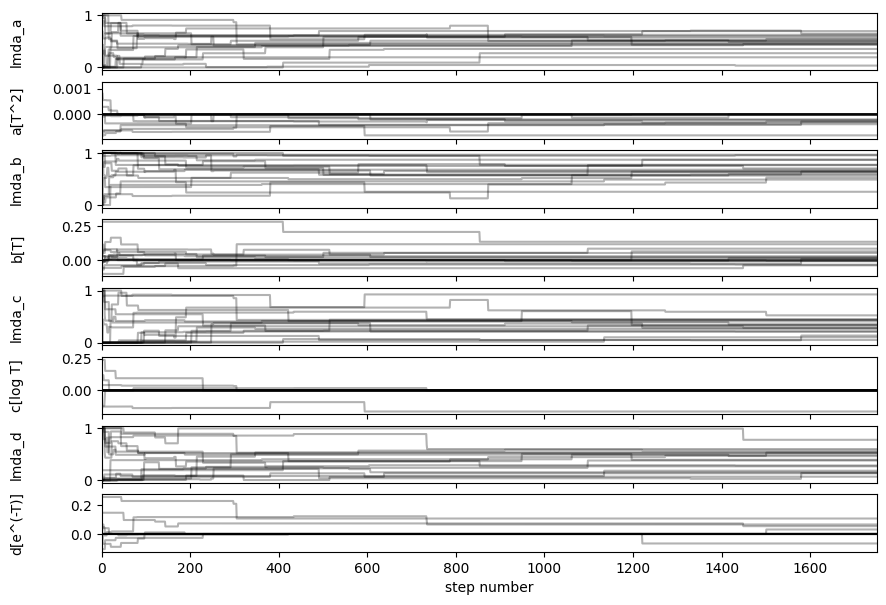

In [14]:
chain_data = np.loadtxt(json_object.get('MCMC').get('posterior'), delimiter=',')
posterior = chain_data.reshape(chain_data.shape[0], chain_data.shape[1]// ndim, ndim)
posterior =posterior[:,:,:]
# chain_state/step number, chain_index, parameter_index
labels = json_object.get('MCMC').get('param_list') # Change the labels over here if changes in parameters are made in json file.

import matplotlib.pyplot as plt
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax = axes[i]
    ax.plot(posterior[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(posterior))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

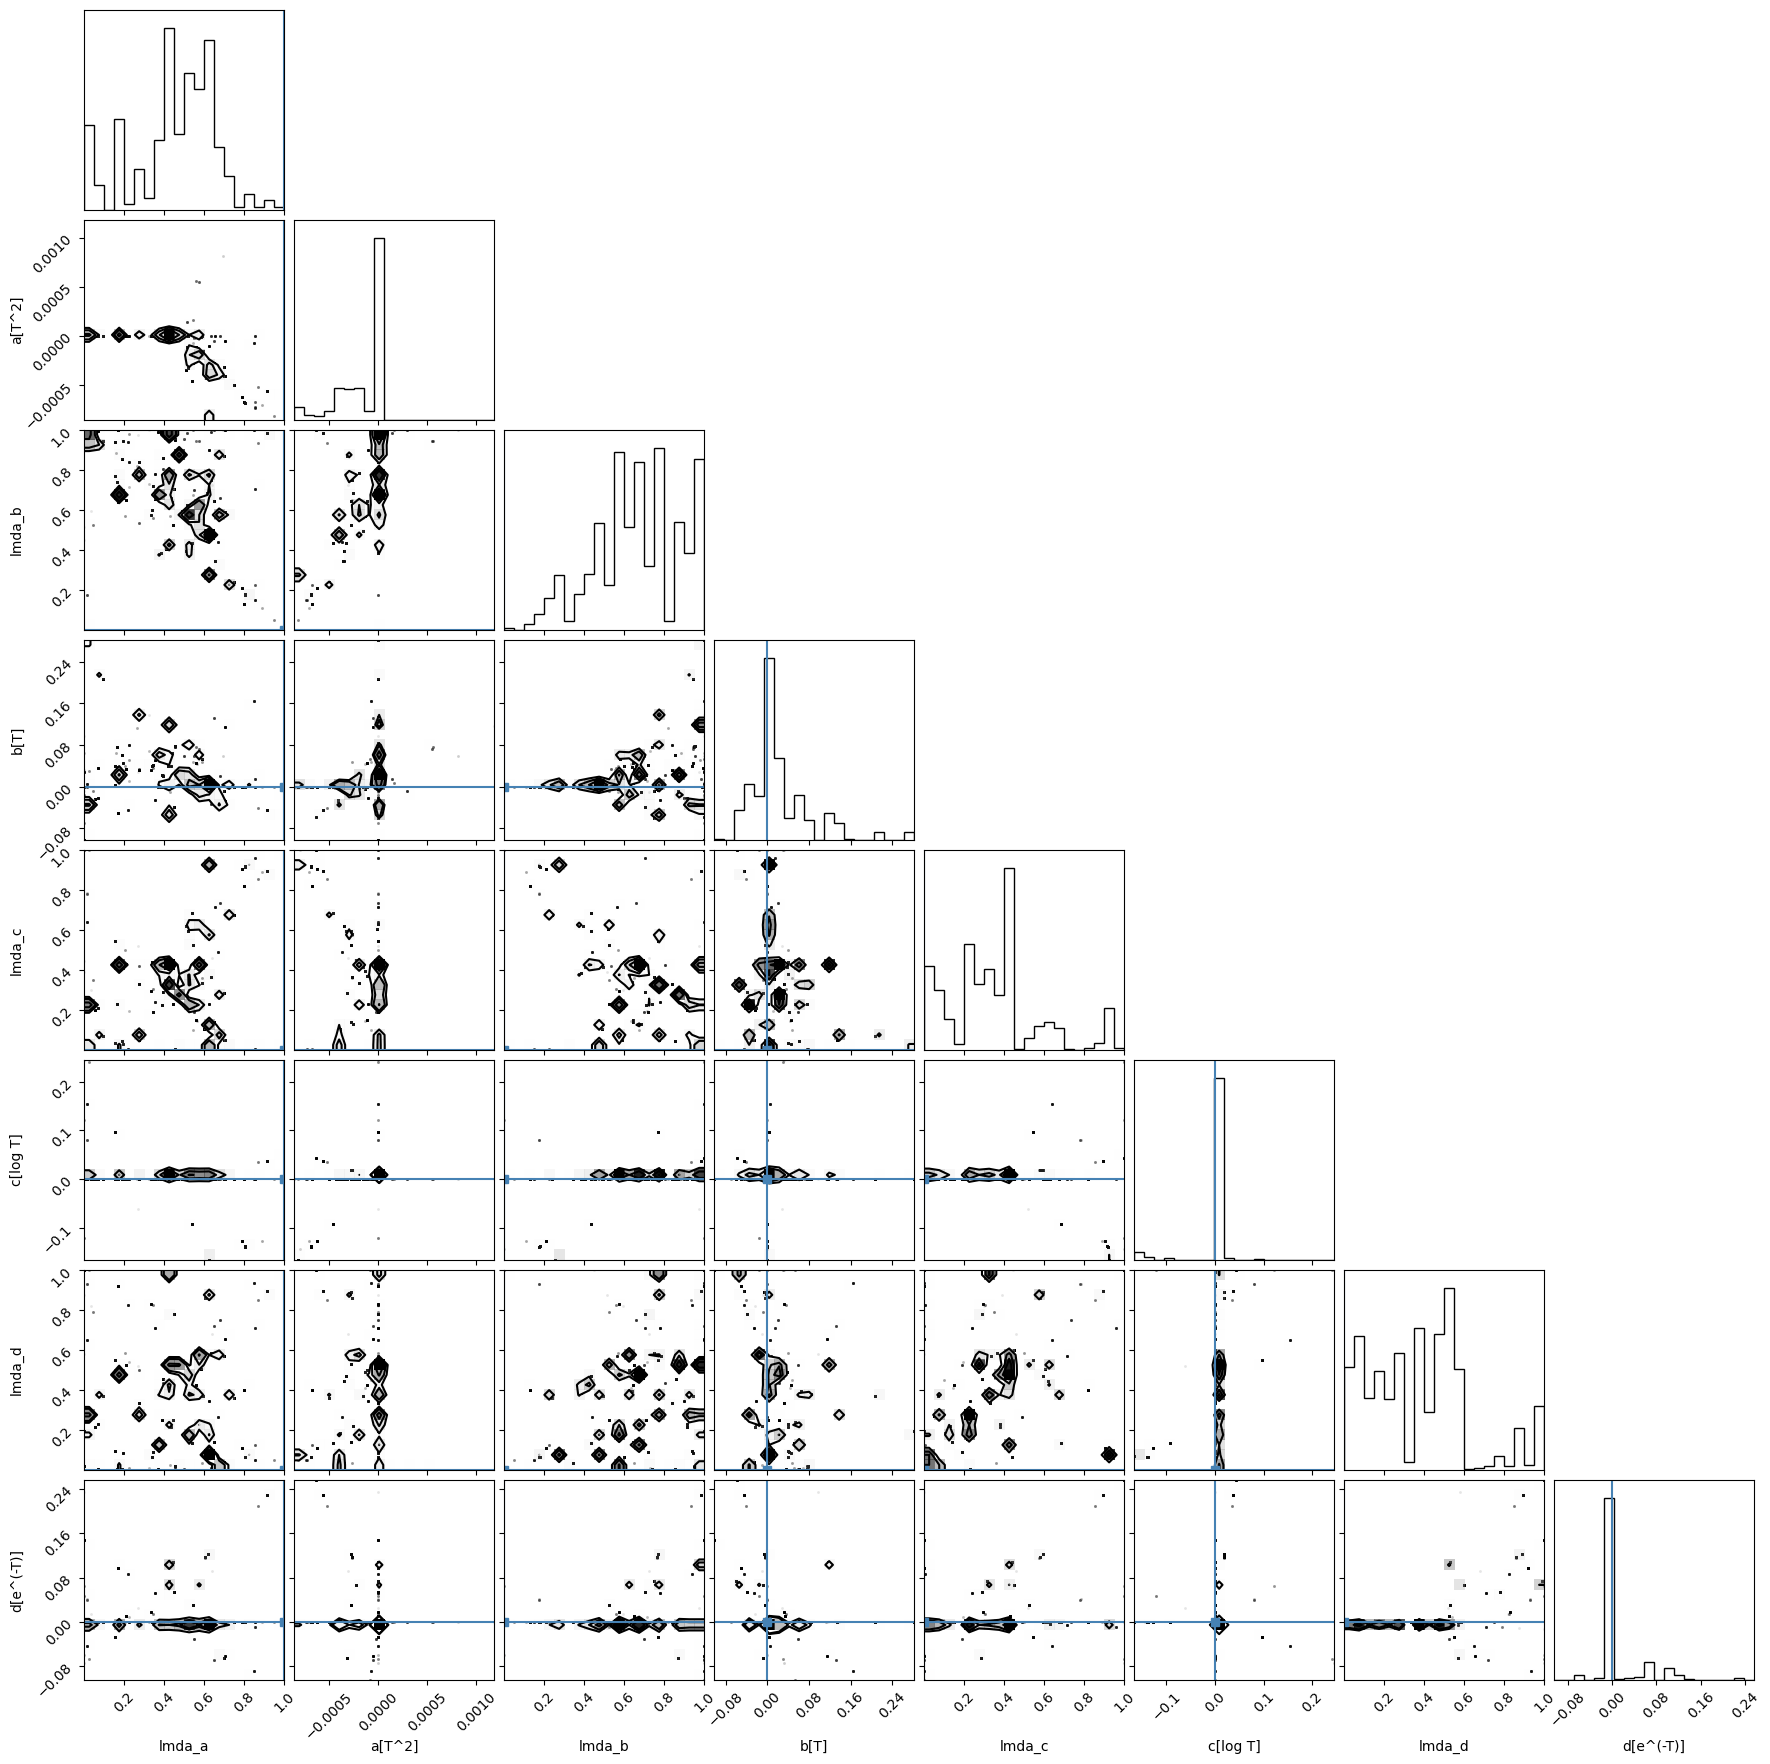

In [15]:
import corner
flat_samples = posterior.reshape(-1, ndim)
fig = corner.corner(
    flat_samples, labels=labels, truths=json_object.get('MCMC').get('true_values')
)

Plotting with rounded off parameters

In [ ]:
for arr_ind_i, matrix in enumerate(posterior):
    for arr_ind_j, row in enumerate(matrix):
        #print(row.shape)
        for arr_ind_k, element in enumerate(row[0:-1:2]):
                #print(arr_ind_k)
                #if arr_ind_k%2 == 0 and element < 0.5:
                if element < 0.5:
                    posterior[arr_ind_i,arr_ind_j,2*arr_ind_k] = 0
                    posterior[arr_ind_i,arr_ind_j,2*arr_ind_k+1] = 0
                else:
                    posterior[arr_ind_i,arr_ind_j,2*arr_ind_k] = 1

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = json_object.get('MCMC').get('param_list')
for i in range(ndim):
    ax = axes[i]
    ax.plot(posterior[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(posterior))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [ ]:
flat_samples = posterior.reshape(-1, ndim)
fig = corner.corner(
    flat_samples, labels=labels, truths=json_object.get('MCMC').get('true_values')
)

This part is for comparison with the other stored chains and doing analysis using plots.

In [ ]:
T = np.linspace(15,35,5)
s = 235-0.04*T**2
chain_idx = -1
walker_idx = 2
Youngs_Mod = 235 + scaler*posterior[chain_idx, walker_idx, 1]*T**2 + posterior[chain_idx, walker_idx, 3]*T + posterior[chain_idx, walker_idx, 5]*np.log(T) + posterior[chain_idx, walker_idx, 7]*np.exp(-T)
fig, ax = plt.subplots()
ax.plot(T, s, marker='o')
ax.plot(T, Youngs_Mod)

ax.set(xlabel='Temp (s)', ylabel='E ',
       title='Youngs Modulus vs Temperature')
ax.grid()

#fig.savefig("test.png")
plt.show()


In [ ]:
#samples = sampler.get_chain(discard=1000, thin=15, flat=True)
sum(posterior[:,:,0] > 0.5)/500